In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import anndata as an
import scanpy as sc

from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Read datafiles

In [2]:
data_path = '../SourceData/Figure4/'

sc_ad_recorded = sc.read_h5ad(data_path + 'st_ad_recorded_filtered.h5ad')
ad_ephy = sc.read_h5ad(data_path + 'ad_ephy.h5ad')
ad_local_comp = sc.read_h5ad(data_path + 'ad_local_cell_composition.h5ad')


# Comparing between cell niche (Figure 4a)

## gene

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_38954/3463707223.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_expression_top['cell_niche'] = cell_niche


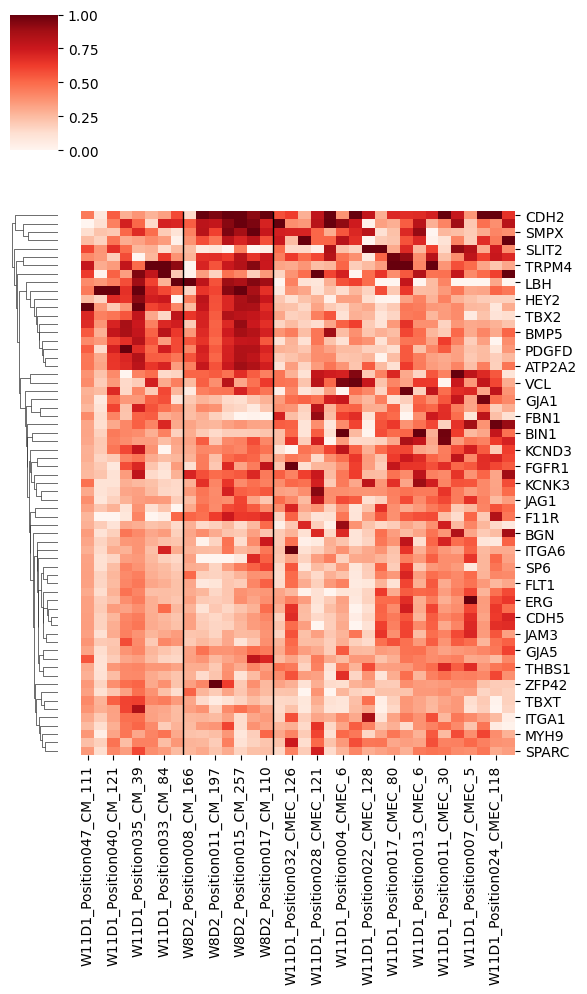

In [3]:
gene_expression = pd.DataFrame(sc_ad_recorded.X, index=sc_ad_recorded.obs.index, columns=sc_ad_recorded.var_names)
cell_niche = sc_ad_recorded.obs['niche']

gene_stats = []

for gene in gene_expression.columns:
    group1 = gene_expression[cell_niche == 'Niche_1'][gene]
    group2 = gene_expression[cell_niche == 'Niche_2'][gene]
    group3 = gene_expression[cell_niche == 'Niche_3'][gene]
    
    f_stat, p_value = f_oneway(group1, group2, group3)
    
    gene_stats.append({
        'Gene': gene,
        'F-stat': f_stat,
        'p-value': p_value
    })

gene_stats_df = pd.DataFrame(gene_stats)

ranked_genes = gene_stats_df.sort_values('p-value')

top_genes = ranked_genes.head(65)['Gene'].tolist()

gene_expression_top = gene_expression[top_genes]

gene_expression_top['cell_niche'] = cell_niche

gene_expression_top_sorted = gene_expression_top.sort_values('cell_niche')
gene_expression_top_sorted_data = gene_expression_top_sorted.drop('cell_niche', axis=1)

g = sns.clustermap(gene_expression_top_sorted_data.T, 
                   metric="euclidean", 
                   method="average", 
                   cmap="Reds", 
                   row_cluster=True,  
                   col_cluster=False,  
                   standard_scale=1, 
                   dendrogram_ratio = (0.1, 0.2),
                   figsize=(6, 10)) 

n_niche_type_1 = (gene_expression_top_sorted['cell_niche'] == 'Niche_1').sum()
n_niche_type_2 = (gene_expression_top_sorted['cell_niche'] == 'Niche_1').sum() + (gene_expression_top_sorted['cell_niche'] == 'Niche_2').sum()
g.ax_heatmap.vlines(n_niche_type_1, *g.ax_heatmap.get_ylim(), color='black', lw=1)
g.ax_heatmap.vlines(n_niche_type_2, *g.ax_heatmap.get_ylim(), color='black', lw=1)

plt.tight_layout()
plt.show()


## ephy

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_38954/3606746016.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephy_expression_top['cell_niche'] = cell_niche


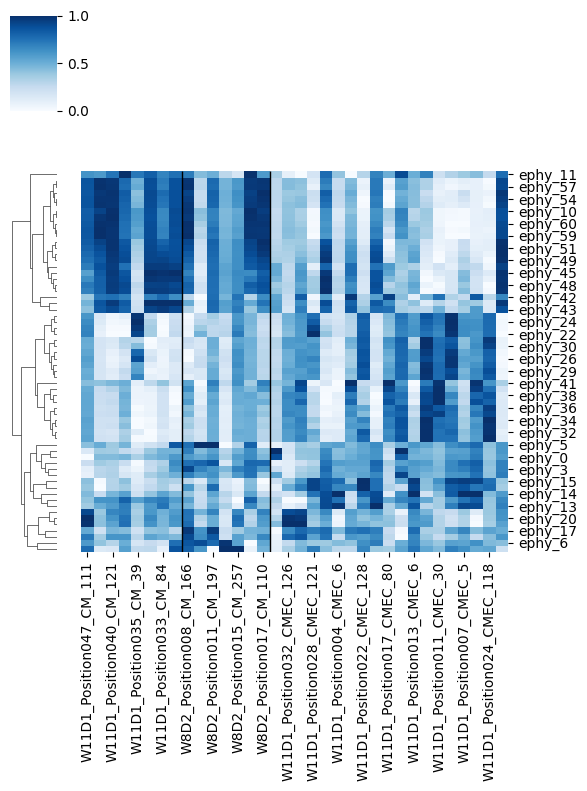

In [4]:
ephy_expression = pd.DataFrame(ad_ephy.X, index=ad_ephy.obs.index, columns=ad_ephy.var_names)
cell_niche = ad_ephy.obs['niche']

ephy_stats = []

for ephy in ephy_expression.columns:
    group1 = ephy_expression[cell_niche == 'Niche_1'][ephy]
    group2 = ephy_expression[cell_niche == 'Niche_2'][ephy]
    group3 = ephy_expression[cell_niche == 'Niche_3'][ephy]
    
    f_stat, p_value = f_oneway(group1, group2, group3)
    
    ephy_stats.append({
        'Feature': ephy,
        'F-stat': f_stat,
        'p-value': p_value
    })

ephy_stats_df = pd.DataFrame(ephy_stats)

ranked_features = ephy_stats_df.sort_values('p-value')

top_features = ranked_features['Feature'].tolist()

ephy_expression_top = ephy_expression[top_features]
ephy_expression_top['cell_niche'] = cell_niche

ephy_expression_top_sorted = ephy_expression_top.sort_values('cell_niche')
ephy_expression_top_sorted_data = ephy_expression_top_sorted.drop('cell_niche', axis=1)


g = sns.clustermap(ephy_expression_top_sorted_data.T, 
                   metric="euclidean", 
                   method="average", 
                   cmap="Blues", 
                   row_cluster=True,  
                   col_cluster=False,  
                   standard_scale=1,  
                   dendrogram_ratio = (0.1, 0.2),
                   figsize=(6, 8)) 

n_niche_type_1 = (ephy_expression_top_sorted['cell_niche'] == 'Niche_1').sum()
n_niche_type_2 = (ephy_expression_top_sorted['cell_niche'] == 'Niche_1').sum() + (ephy_expression_top_sorted['cell_niche'] == 'Niche_2').sum()
g.ax_heatmap.vlines(n_niche_type_1, *g.ax_heatmap.get_ylim(), color='black', lw=1)
g.ax_heatmap.vlines(n_niche_type_2, *g.ax_heatmap.get_ylim(), color='black', lw=1)

plt.tight_layout()
plt.show()

## Cell composition

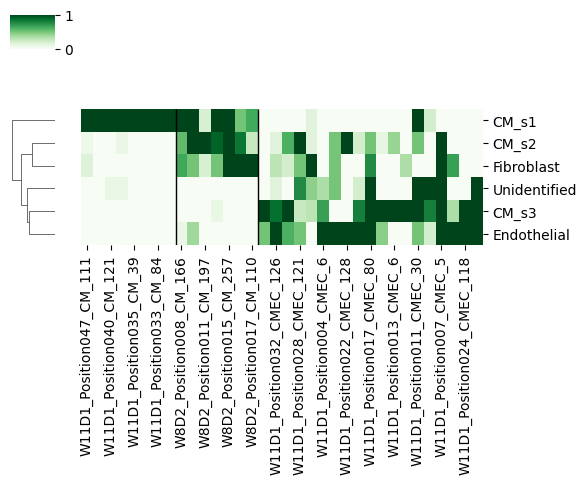

In [5]:
local_comp = pd.DataFrame(ad_local_comp.X, index=ad_local_comp.obs.index, columns=ad_local_comp.var_names)
local_comp['cell_niche'] = ad_local_comp.obs['niche']

local_comp_sorted = local_comp.sort_values('cell_niche')
local_comp_sorted = local_comp_sorted.drop('cell_niche', axis=1)

local_composition_data_transposed = local_comp_sorted.T 

g = sns.clustermap(local_composition_data_transposed, 
                   metric="euclidean", 
                   method="average", 
                   cmap="Greens", 
                   row_cluster=True,  
                   col_cluster=False,  
                   standard_scale=True,  
                   dendrogram_ratio=(0.1, 0.2),
                   figsize=(6, 5)) 

n_cell_niche_1 = (local_comp['cell_niche'] == 'Niche_1').sum()
n_cell_niche_2 = (local_comp['cell_niche'] == 'Niche_1').sum() + (local_comp['cell_niche'] == 'Niche_2').sum()
g.ax_heatmap.vlines(n_cell_niche_1, *g.ax_heatmap.get_ylim(), color='black', lw=1)
g.ax_heatmap.vlines(n_cell_niche_2, *g.ax_heatmap.get_ylim(), color='black', lw=1)

plt.tight_layout()
plt.show()

# Figure 4e

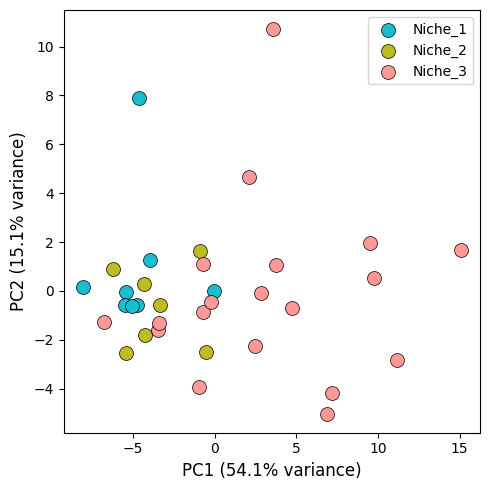

In [6]:
palette_niche = {'Niche_1': '#17becf', 'Niche_2': '#bcbd22', 'Niche_3': '#ff9896'}

var_ratio = ad_ephy.uns['pca']['variance_ratio']
pc1_var = var_ratio[0] * 100
pc2_var = var_ratio[1] * 100

# Extract PCA coordinates
pca_coords = ad_ephy.obsm['X_pca']
pc1 = pca_coords[:, 0]
pc2 = pca_coords[:, 1]

niche_colors = [palette_niche.get(niche, 'gray') for niche in ad_ephy.obs['niche']]
cell_types = ad_ephy.obs['cell_type']

fig, ax = plt.subplots(figsize=(5, 5)) 
for niche, color in palette_niche.items():
    mask = ad_ephy.obs['niche'] == niche
    ax.scatter(pc1[mask], pc2[mask], c=color, s=100, label=niche, edgecolors='black', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pc1_var:.1f}% variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pc2_var:.1f}% variance)', fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.legend(fontsize=10)

plt.tight_layout()  
plt.show()

# Figure 4f

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_38954/1446183632.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


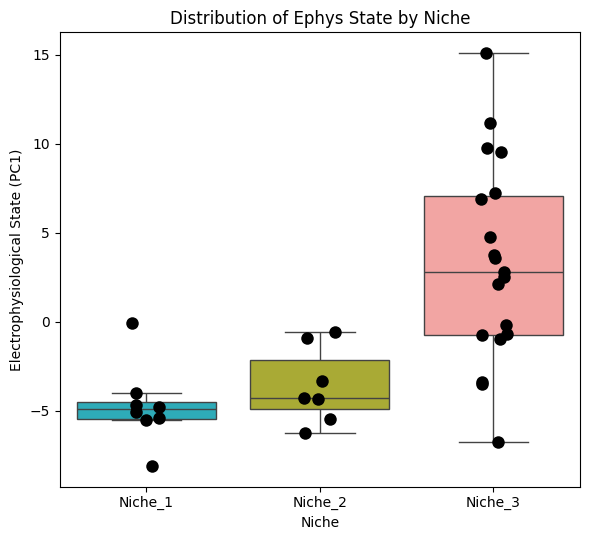

In [7]:
plot_data = pd.DataFrame({
    'pca1': ad_ephy.obs['ephy_pca1'],
    'niche': ad_ephy.obs['niche']
})

palette_niche = {'Niche_1': '#17becf', 'Niche_2': '#bcbd22', 'Niche_3': '#ff9896'}

plt.figure(figsize=(6, 5.5))

order = ['Niche_1', 'Niche_2', 'Niche_3']

sns.boxplot(
    data=plot_data,
    x='niche',
    y='pca1',
    palette=palette_niche,
    order=order,
    showfliers=False,
)

sns.stripplot(
    data=plot_data,
    x='niche',
    y='pca1',
    order=order,
    color='black', 
    jitter=0.1,     
    size=9
)

plt.xlabel('Niche')
plt.ylabel('Electrophysiological State (PC1)')
plt.title('Distribution of Ephys State by Niche')

plt.tight_layout()
plt.show()

# Figure 4g

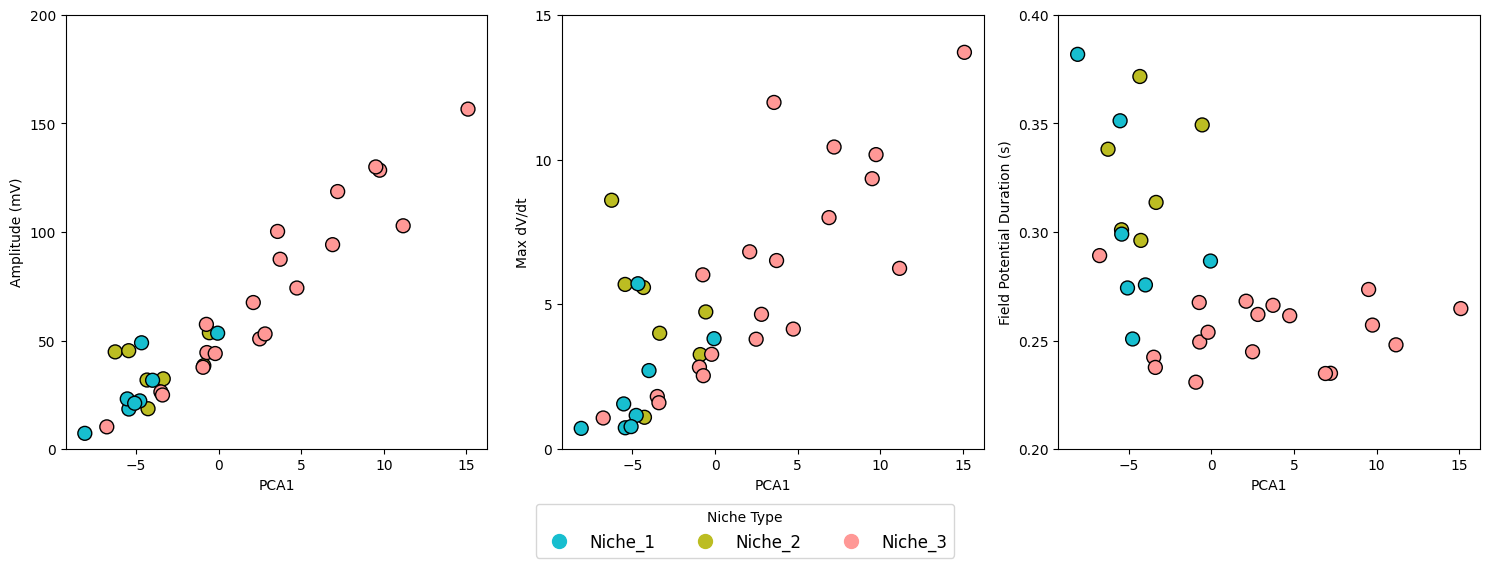

In [8]:
ephy_PC1 = ad_ephy.obs['ephy_pca1']
waveform_amplitude = ad_ephy.uns['Spike Amplitude']          
waveform_dvdt = ad_ephy.uns['Max dVdt']                     
waveform_FPD = ad_ephy.uns['Field Potential Duration (s)']  
cell_type = ad_ephy.obs['cell_type']
niche_type = ad_ephy.obs['niche']

palette_niche = {'Niche_1': '#17becf', 'Niche_2': '#bcbd22', 'Niche_3': '#ff9896'}
niche_type_colors = niche_type.map(palette_niche)  

fig, axes = plt.subplots(1, 3, figsize=(15, 5.7), sharex=True)

axes[0].scatter(
    ephy_PC1, waveform_amplitude, 
    c=niche_type_colors, edgecolor='k', s=100
)
axes[0].set_xlabel("PCA1")
axes[0].set_ylabel("Amplitude (mV)")
axes[0].set_yticks([0, 50, 100, 150, 200])  
axes[0].set_ylim(0, 200)  

axes[1].scatter(
    ephy_PC1, waveform_dvdt, 
    c=niche_type_colors, edgecolor='k', s=100
)
axes[1].set_xlabel("PCA1")
axes[1].set_ylabel("Max dV/dt")
axes[1].set_yticks([0, 5, 10, 15])  
axes[1].set_ylim(0, 15)  

axes[2].scatter(
    ephy_PC1, waveform_FPD, 
    c=niche_type_colors, edgecolor='k', s=100
)
axes[2].set_xlabel("PCA1")
axes[2].set_ylabel("Field Potential Duration (s)")
axes[2].set_yticks([0.2, 0.25, 0.3, 0.35, 0.4])  
axes[2].set_ylim(0.2, 0.4)  

handles = [plt.Line2D([0], [0], marker='o', color=color, label=niche, linestyle='', markersize=10)
           for niche, color in palette_niche.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(palette_niche), fontsize=12, title="Niche Type")

plt.tight_layout(rect=[0, 0.1, 1, 1])  
plt.show()